# Noise Estimation using Correlation Methods
In this tutorial, we will demonstrate how to use 2-channel and 3-channel correlation methods,`kontrol.spectral.two_channel_correlation()` and `kontrol.spectral.three_channel_correlation()`, to estimate sensor self noise. Library reference is available [here](https://kontrol.readthedocs.io/en/latest/main_utilities.html#spectral-analysis-functions).
Description of this method is available in the baseline method section of [here](https://github.com/gw-vis/vis-commissioning-tex). We will also use notations in the document.

Let's say we have three sensors, with readouts $y_1(t)$, $y_2(t)$, and $y_3(t)$.
We place them in a position such that they sense a coherent signal

$x(t)=\Re\left(Ae^{\left(\sigma+i\omega_0e^{\gamma t}\right)t}\right)$,

where $i$ is the imaginary number, $A$ is $A$ is a real number, $\sigma$ and $\gamma$ are negative real numbers, and $\omega_0$ is a positive real number.

The first two sensors have dynamics

$H_1(s)=H_2(s)=\frac{s^2}{s^2+2\zeta\omega_ns+\omega_n^2}$,

where $\zeta>0$ and $\omega_n>0$, and the third sensor has dynamics

$H_3(s)=\frac{\omega_m}{s+\omega_m}$.

The sensors have noise dynamics

$N_i(s)=G_i(s)W_i(s)$,

where $i=1,2,3$, $W_i(s)$ is white noise with unit amplitude, and $G_i(s)$ is the noise dynamics of the sensors. Here, $W_i(s)$s are uncorrelated.
Let's say

$G_1(s)=G_2(s)=\frac{a_1}{s+\epsilon_1}$ and $G_3(s)=\frac{a_3}{(s+\epsilon_3)^2}$,

where $a_1$ and $a_3$ real number, $\epsilon_1$ and $\epsilon_3$ are real numbers, and $\epsilon_1\approx\epsilon_3\ll\omega_0$.

The readouts are then simply

$y_i(t) = \mathcal{L}^{-1}\left\{X(s)H_i(s) + N_i(s)\right\}$.

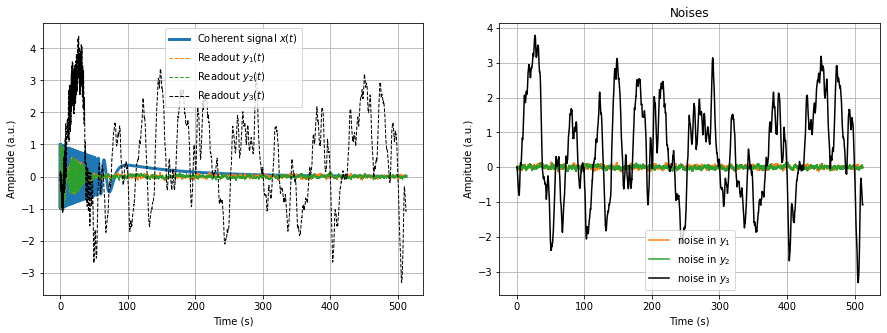

In [1]:
import control
import numpy as np
import matplotlib.pyplot as plt


np.random.seed(123)

# Time axis and sampling frequency
fs = 128
t0 = 0
t_end = 512
t = np.arange(t0, t_end, 1/fs)

# The coherent signal
A = 1
sigma = -.01
gamma = -0.1
omega_0 = 10*2*np.pi
x = A*np.exp((sigma + 1j*omega_0*np.exp(gamma*t)) * t).real

# The sensor dynamics.
zeta = 1 
omega_n = 1*2*np.pi
omega_m = 10
s = control.tf("s")
H1 = s**2 / (s**2 + 2*zeta*omega_n*s + omega_n**2)
H2 = H1
H3 = omega_m / (s+omega_m)

# Signals sensed by the sensors.
_, x1 = control.forced_response(sys=H1, T=t, U=x)
_, x2 = control.forced_response(sys=H2, T=t, U=x)
_, x3 = control.forced_response(sys=H3, T=t, U=x)

# The noises
w1 = np.random.normal(loc=0, scale=1, size=len(t))
w2 = np.random.normal(loc=0, scale=1, size=len(t))
w3 = np.random.normal(loc=0, scale=1, size=len(t))
a1 = 0.5
a3 =5
epsilon_1 = omega_0/100
epsilon_3 = omega_0/200
G1 = a1 / (s+epsilon_1)
G2 = G1
G3 = a3 / (s+epsilon_3)**2
_, n1 = control.forced_response(sys=G1, T=t, U=w1)
_, n2 = control.forced_response(sys=G2, T=t, U=w2)
_, n3 = control.forced_response(sys=G3, T=t, U=w3)

# The readouts
y1 = x1 + n1
y2 = x2 + n2
y3 = x3 + n3

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(t, x, label="Coherent signal $x(t)$", lw=3)
plt.plot(t, y1, "--", label="Readout $y_1(t)$", lw=1)
plt.plot(t, y2, "--", label="Readout $y_2(t)$", lw=1)
plt.plot(t, y3, "k--", label="Readout $y_3(t)$", lw=1)
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Ampitude (a.u.)")
plt.xlabel("Time (s)")

plt.subplot(122, title="Noises")
plt.plot(1,1)  # just to shift the colors.
plt.plot(t, n1, label="noise in $y_1$")
plt.plot(t, n2, label="noise in $y_2$")
plt.plot(t, n3, "k", label="noise in $y_3$")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Ampitude (a.u.)")
plt.xlabel("Time (s)")

plt.show()

Let's plot the PSDs

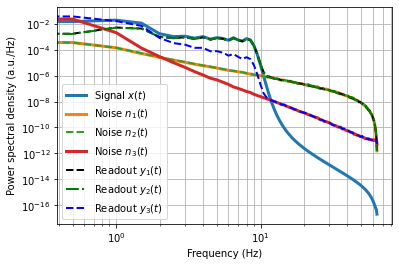

In [2]:
import scipy.signal

f, P_x = scipy.signal.welch(x, fs=fs)
f, P_n1 = scipy.signal.welch(n1, fs=fs)
f, P_n2 = scipy.signal.welch(n2, fs=fs)
f, P_n3 = scipy.signal.welch(n3, fs=fs)
f, P_y1 = scipy.signal.welch(y1, fs=fs)
f, P_y2 = scipy.signal.welch(y2, fs=fs)
f, P_y3 = scipy.signal.welch(y3, fs=fs)

plt.figure(figsize=(6, 4))
plt.loglog(f, P_x, label="Signal $x(t)$", lw=3)
plt.loglog(f, P_n1, label="Noise $n_1(t)$", lw=3)
plt.loglog(f, P_n2, "--", label="Noise $n_2(t)$", lw=2)
plt.loglog(f, P_n3, label="Noise $n_3(t)$", lw=3)
plt.loglog(f, P_y1, "k--", label="Readout $y_1(t)$", lw=2)
plt.loglog(f, P_y2, "g-.", label="Readout $y_2(t)$", lw=2)
plt.loglog(f, P_y3, "b--", label="Readout $y_3(t)$", lw=2)
plt.legend(loc=0)
plt.grid(which="both")
# plt.ylim(1e-9, 1e-1)
# plt.xlim(0.5, 10)
plt.ylabel("Power spectral density (a.u./Hz)")
plt.xlabel("Frequency (Hz)")

plt.show()

## Two-channel method
Sensor 1 and sensor 2 has the same dynamics and noise PSD.
Let's see if we can predict the two noises using the two-channel correlation method.
Here, we will use Kontrol spectral analysis utilities.

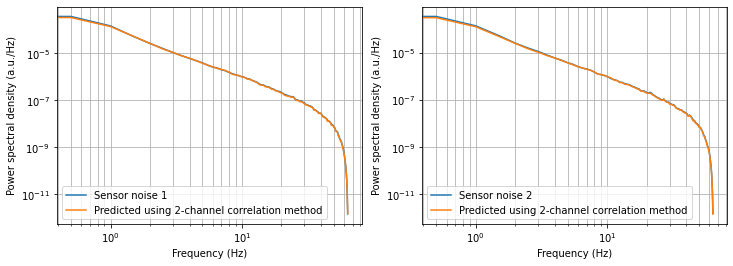

In [3]:
import kontrol


_, coh12 = scipy.signal.coherence(y1, y2, fs=fs)
_, coh21 = scipy.signal.coherence(y2, y1, fs=fs)  # This is actually the same as coh21
P_n1_2channel = kontrol.spectral.two_channel_correlation(psd=P_y1, coh=coh12)
P_n2_2channel = kontrol.spectral.two_channel_correlation(psd=P_y2, coh=coh21)

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.loglog(f, P_n1, label="Sensor noise 1")
plt.loglog(f, P_n1_2channel, label="Predicted using 2-channel correlation method")
plt.legend(loc=0)
plt.grid(which="both")
# plt.ylim(1e-7, 1e-3)
# plt.xlim(0.5, 10)
plt.ylabel("Power spectral density (a.u./Hz)")
plt.xlabel("Frequency (Hz)")

plt.subplot(122)
plt.loglog(f, P_n2, label="Sensor noise 2")
plt.loglog(f, P_n2_2channel, label="Predicted using 2-channel correlation method")
plt.legend(loc=0)
plt.grid(which="both")
# plt.ylim(1e-7, 1e-3)
# plt.xlim(0.5, 10)
plt.ylabel("Power spectral density (a.u./Hz)")
plt.xlabel("Frequency (Hz)")

plt.show()

As can be seen, the 2-channnel method works perfectly in predicting the sensor noises using only the readouts.

Just curious to see what happens if we use sensor 3, which is not the same as sensor 1 and 2, instead.

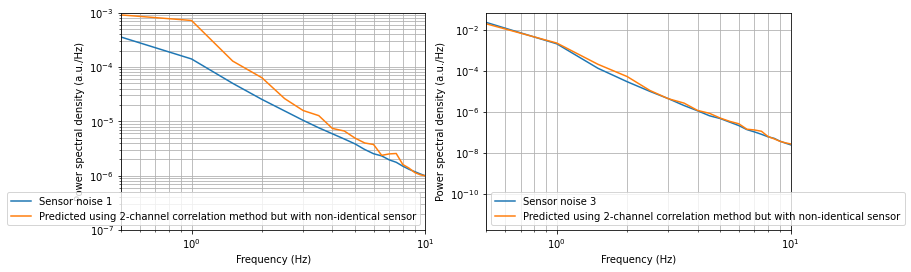

In [4]:
_, coh13 = scipy.signal.coherence(y1, y3, fs=fs)
_, coh31 = scipy.signal.coherence(y3, y1, fs=fs)  # This is actually the same as coh21


P_n1_2channel_from_n3 = kontrol.spectral.two_channel_correlation(psd=P_y1, coh=coh13)
P_n3_2channel_from_n1 = kontrol.spectral.two_channel_correlation(psd=P_y3, coh=coh31)

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.loglog(f, P_n1, label="Sensor noise 1")
plt.loglog(f, P_n1_2channel_from_n3, label="Predicted using 2-channel correlation method but with non-identical sensor")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylim(1e-7, 1e-3)
plt.xlim(0.5, 10)
plt.ylabel("Power spectral density (a.u./Hz)")
plt.xlabel("Frequency (Hz)")

plt.subplot(122)
plt.loglog(f, P_n3, label="Sensor noise 3")
plt.loglog(f, P_n3_2channel_from_n1, label="Predicted using 2-channel correlation method but with non-identical sensor")
plt.legend(loc=0)
plt.grid(which="both")
# plt.ylim(1e-7, 1e-3)
plt.xlim(0.5, 10)
plt.ylabel("Power spectral density (a.u./Hz)")
plt.xlabel("Frequency (Hz)")

plt.show()

Interesting, somehow gets the sensor 3 noise more accurately than that of sensor 1. But it could be just a fluke.

## Three-channel correlation method

Now, let's compute the sensors noise using the three-channel method.

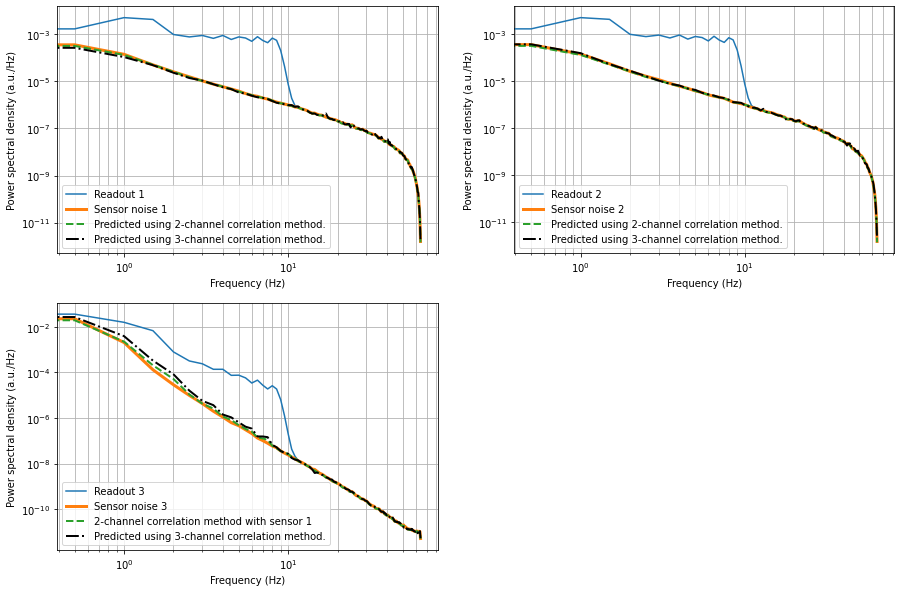

In [5]:
_, csd12 = scipy.signal.csd(y1, y2, fs=fs)
_, csd13 = scipy.signal.csd(y1, y3, fs=fs)
_, csd21 = scipy.signal.csd(y2, y1, fs=fs)
_, csd23 = scipy.signal.csd(y2, y3, fs=fs)
_, csd31 = scipy.signal.csd(y3, y1, fs=fs)
_, csd32 = scipy.signal.csd(y3, y2, fs=fs)

# Calculate all three estimations at the same time.
# At least provide three independent cross-spectral densities.
# But it's recommended to provide all cross-spectral densities.
P_n1_3channel, P_n2_3channel, P_n3_3channel = kontrol.spectral.three_channel_correlation(
    psd1=P_y1, psd2=P_y2, psd3=P_y3,
    csd12=csd12, csd13=csd13,
    csd21=csd21, csd23=csd23,
    csd31=csd31, csd32=csd32)

# # Alternatively, calculate each estimation one by one with the returnall=False tag.
# # Note the changes in the cross-spectral density
# P_n1_3channel = kontrol.spectral.three_channel_correlation(
#     psd1=P_y1, csd13=csd13, csd23=csd23, csd21=csd21, returnall=False)
# P_n2_3channel = kontrol.spectral.three_channel_correlation(
#     psd1=P_y2, csd13=csd21, csd23=csd31, csd21=csd32, returnall=False)
# P_n3_3channel = kontrol.spectral.three_channel_correlation(
#     psd1=P_y3, csd13=csd32, csd23=csd12, csd21=csd13, returnall=False)


plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.loglog(f, P_y1, label="Readout 1")
plt.loglog(f, P_n1, label="Sensor noise 1", lw=3)
plt.loglog(f, P_n1_2channel, "--", label="Predicted using 2-channel correlation method.", lw=2)
plt.loglog(f, P_n1_3channel, "k-.", label="Predicted using 3-channel correlation method.", lw=2, markersize=3)
plt.legend(loc=0)
plt.grid(which="both")
# plt.ylim(1e-7, 1e-2)
# plt.xlim(0.5, 10)
plt.ylabel("Power spectral density (a.u./Hz)")
plt.xlabel("Frequency (Hz)")

plt.subplot(222)
plt.loglog(f, P_y2, label="Readout 2",)
plt.loglog(f, P_n2, label="Sensor noise 2", lw=3)
plt.loglog(f, P_n2_2channel, "--", label="Predicted using 2-channel correlation method.", lw=2)
plt.loglog(f, P_n2_3channel, "k-.", label="Predicted using 3-channel correlation method.", lw=2, markersize=3)
plt.legend(loc=0)
plt.grid(which="both")
# plt.ylim(1e-7, 1e-2)
# plt.xlim(0.5, 10)
plt.ylabel("Power spectral density (a.u./Hz)")
plt.xlabel("Frequency (Hz)")

plt.subplot(223)
plt.loglog(f, P_y3, label="Readout 3")
plt.loglog(f, P_n3, label="Sensor noise 3", lw=3)
plt.loglog(f, P_n3_2channel_from_n1, "--", label="2-channel correlation method with sensor 1", lw=2)
plt.loglog(f, P_n3_3channel, "k-.", label="Predicted using 3-channel correlation method.", lw=2, markersize=3)
plt.legend(loc=0)
plt.grid(which="both")
# plt.ylim(1e-9, 1e-1)
# plt.xlim(0.5, 10)
plt.ylabel("Power spectral density (a.u./Hz)")
plt.xlabel("Frequency (Hz)")
plt.show()